# COVID-19 Growth Rate Prediction
> Predictions of COVID-19 Growth Rates Using Bayesian Modeling

- comments: true
- author: Thomas Wiecki
- categories: [growth]
- image: images/covid-bayesian.png
- permalink: /growth-bayes/

In [2]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt

import load_covid_data

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [10]:
x = np.random.randn(50)
print('mu =', np.mean(x))
print('sigma =', np.std(x))

mu = -0.14818140406792174
sigma = 0.9789529159444097


In [15]:
with pm.Model() as model:
    mu = pm.Normal('mu', 0, 1)
    sigma = pm.HalfNormal('sigma')
    pm.Normal('x', mu=mu, sigma=sigma, observed=x)
    trace = pm.sample(chains=1, draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


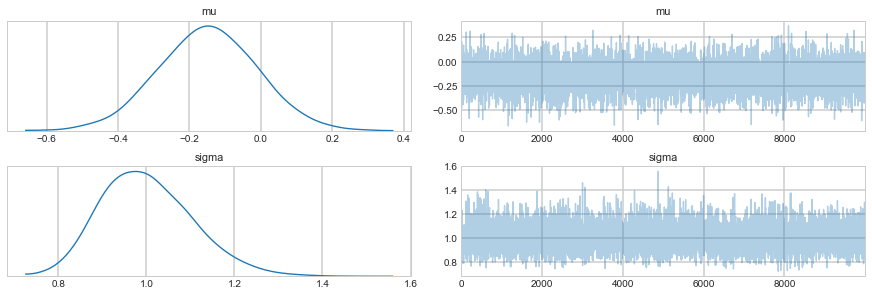

In [16]:
pm.traceplot(trace);

## Data

In [192]:
#hide

df = load_covid_data.load_data_ecdc(filter_n_days_100=15)
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
df = df.loc[lambda x: ~x.country.isin(['International', 'World', 'China', 'San Marino'])]
                                       #, 'Singapore', 'Norway' , 
                                       #'Netherlands', 'Bahrain', 'Australia', 'Iran'])]

countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]

pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations_all = pd.read_csv(pop_file)
populations_all = populations_all.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()
populations_all.loc['Egypt'] = populations_all.loc['Egypt, Arab Rep.'].Value
populations_all.loc['Iran'] = populations_all.loc['Iran, Islamic Rep.'].Value
populations_all.loc['South Korea'] = populations_all.loc['Korea, Rep.'].Value
populations_all.loc['Hong Kong'] = populations_all.loc['Hong Kong SAR, China'].Value
populations_all.loc['Czechia'] = populations_all.loc['Czech Republic'].Value

c = populations_all.index.intersection(countries)
populations = populations_all.loc[c, 'Value']
populations.name = 'population'

df['deaths_per_100000'] = (100000 * df.set_index('country')['deaths'] / populations).values
df['confirmed_per_1000'] = (1000 * df.set_index('country')['confirmed'] / populations).values
df['confirmed_pct_change'] = df.groupby('country').confirmed.pct_change()
df['deaths_pct_change'] = df.groupby('country').deaths.pct_change()
df = df.dropna()
df = df.loc[lambda x: x.confirmed_pct_change != 0]

countries_sel = (df.groupby('country').deaths_per_100000.last() > .1).loc[lambda x: x].index.tolist()
df = df.loc[df.country.isin(countries_sel)]

countries = df.country.unique()
n_countries = len(countries)
c = populations_all.index.intersection(countries)
populations = populations_all.loc[c, 'Value']
populations.name = 'population'

These are the countries included in the model:

In [149]:
#hide_input
for c in countries:
    print(c)

Austria
Bahrain
Belgium
Canada
China
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Iceland
Iran
Iraq
Ireland
Israel
Italy
Lebanon
Malaysia
Netherlands
Norway
Portugal
Romania
San Marino
Slovenia
South Korea
Spain
Sweden
Switzerland
United Kingdom
United States
World


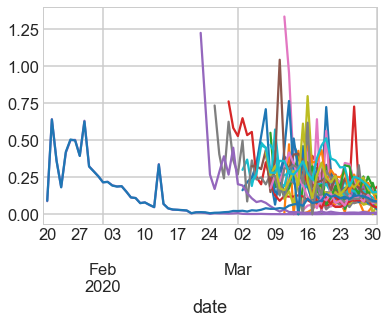

In [10]:
df.groupby('country').confirmed_pct_change.plot();

In [12]:
countries

array(['Austria', 'Bahrain', 'Belgium', 'Canada', 'China',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Iran', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Malaysia', 'Netherlands', 'Norway', 'Portugal',
       'Romania', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'United States', 'World'],
      dtype=object)

In [32]:
idx_country = pd.Index(countries).get_indexer(df.country)
#idx_data_time = data_time.get_indexer(df_sign.date)
#idx_previous_time = data_time.get_indexer(df_sign.previous_date)

In [45]:
with pm.Model() as model:
    mu_growth = pm.Lognormal('mu_growth', mu=pm.math.log(0.33), 
                             sigma=2., shape=n_countries)
    sigma_growth = pm.HalfNormal('sigma_growth', 2., shape=n_countries)
    
    obs = pm.Lognormal('obs', 
                       mu=pm.math.log(mu_growth[idx_country]), 
                       sigma=sigma_growth[idx_country], 
                       observed=df.confirmed_pct_change)
    
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))
        
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace, 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


mu_growth_log__ -49.97465712670319
sigma_growth_log__ -23.8666703356706
obs 165.92658719094297


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_growth, mu_growth]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.


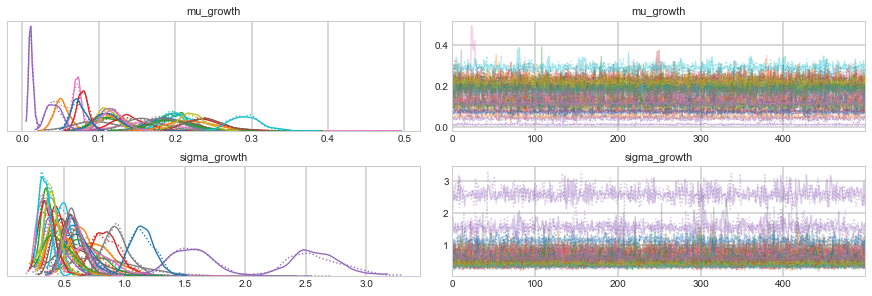

In [46]:
pm.traceplot(trace);

In [104]:
def cumulate(x):
    if len(x.shape) > 1:
        return np.cumprod(1 + x, 0) - 1
    else:
        return np.cumprod(1 + x) - 1

In [79]:
post_pred['obs'][:, idx_country == i].T.shape

(19, 1000)

In [80]:
cumulate(post_pred['obs'][:, idx_country == i].T).shape

(19, 1000)

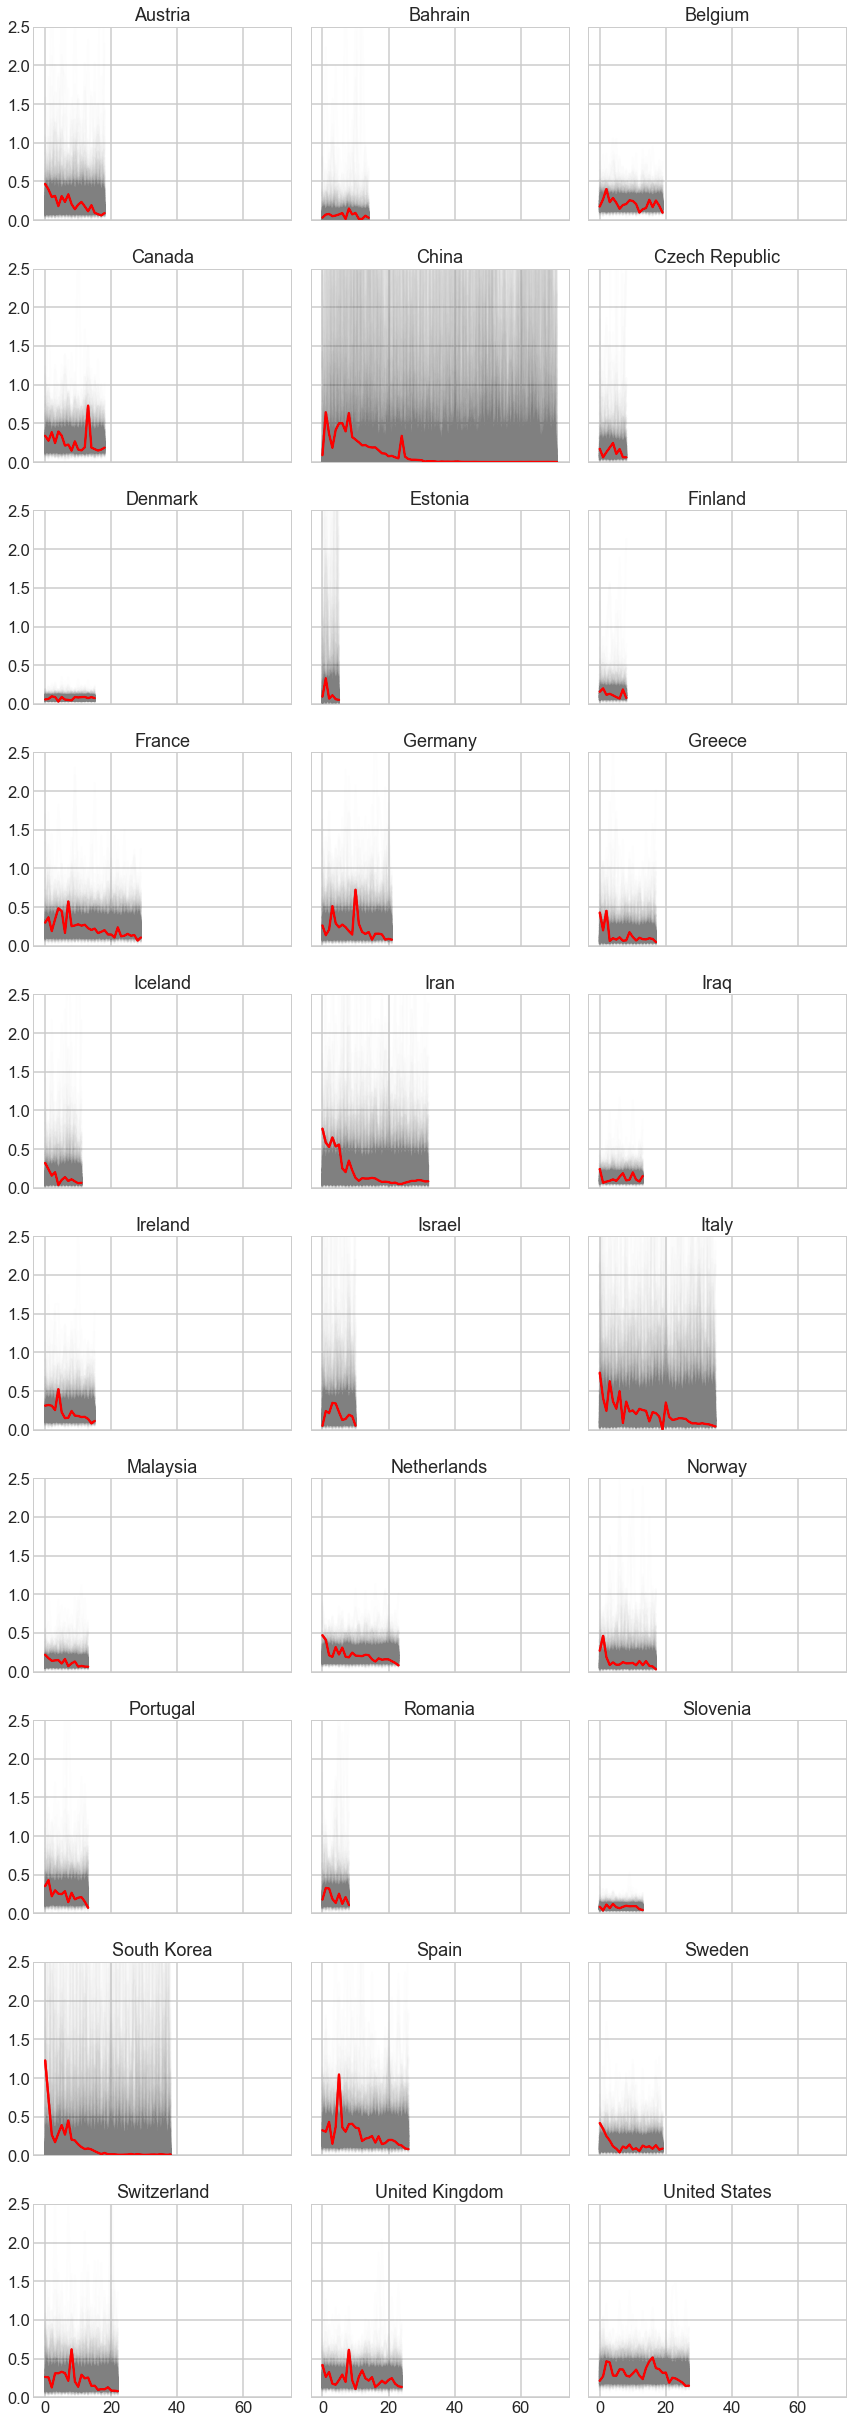

In [83]:
fig, axs = plt.subplots(ncols=3, nrows=n_countries // 3, figsize=(12, 34), sharex=True, sharey=True)
for i, (country, ax) in enumerate(zip(countries, axs.flatten())):
    ax.plot(df.loc[lambda x: x.country == country].confirmed_pct_change.values, color='r')
    ax.plot(post_pred['obs'][:, idx_country == i].T, alpha=.01, color='0.5')
    ax.plot(df.loc[lambda x: x.country == country].confirmed_pct_change.values, color='r')
    ax.set(title=country, ylim=(0, 2.5))
    
fig.tight_layout()

In [200]:
with pm.Model() as model:
    step_width_grp = pm.HalfNormal('step_width_grp', .05)
    step_width = pm.HalfNormal('step_width', step_width_grp, shape=n_countries)
    sigma_growth_grp = pm.HalfNormal('sigma_growth_grp', .5)
    sigma_growth = pm.HalfNormal('sigma_growth', sigma_growth_grp, shape=n_countries)
    
    for i, country in enumerate(countries):
        df_country = df.loc[lambda x: (x.country == country)]

        mu_growth = pm.GaussianRandomWalk('mu_growth_{}'.format(country), 
                                          mu=0, sigma=step_width[i],
                                          shape=len(df_country), testval=0.3)
   
    #         obs = pm.Lognormal(country,
    #                        mu=pm.math.log(mu_growth), 
    #                        sigma=sigma_growth[i], 
    #                        observed=df_country.confirmed_pct_change)

        obs = pm.Normal(country, 
                        mu=mu_growth, 
                        sigma=sigma_growth[i], 
                        observed=df_country.confirmed_pct_change)    
    
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))
        
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace, 100)

step_width_grp_log__ -0.7698925914732455
step_width_log__ -26.94624070156358
sigma_growth_grp_log__ -0.7698925914732455
sigma_growth_log__ -26.94624070156358
mu_growth_Austria 50.567528912775444
mu_growth_Bahrain 40.454023130220364
mu_growth_Belgium 53.095905358414214
mu_growth_Brazil 37.925646684581594
mu_growth_Canada 50.567528912775444
mu_growth_Czech Republic 25.283764456387733
mu_growth_Denmark 42.982399575859134
mu_growth_Ecuador 35.39727023894282
mu_growth_Estonia 17.69863511947141
mu_growth_Finland 25.283764456387733
mu_growth_France 78.37966981480191
mu_growth_Germany 58.152658249691754
mu_growth_Greece 48.039152467136674
mu_growth_Iceland 32.86889379330405
mu_growth_Iran 85.96479915171822
mu_growth_Iraq 35.39727023894282
mu_growth_Ireland 42.982399575859134
mu_growth_Israel 30.34051734766528
mu_growth_Italy 93.54992848863454
mu_growth_Lebanon 35.39727023894282
mu_growth_Luxembourg 35.39727023894282
mu_growth_Malaysia 35.39727023894282
mu_growth_Netherlands 63.209411140969294


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


United States 5.322783657133729


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_growth_United States, mu_growth_United Kingdom, mu_growth_Switzerland, mu_growth_Sweden, mu_growth_Spain, mu_growth_South Korea, mu_growth_Slovenia, mu_growth_Romania, mu_growth_Portugal, mu_growth_Poland, mu_growth_Peru, mu_growth_Norway, mu_growth_Netherlands, mu_growth_Malaysia, mu_growth_Luxembourg, mu_growth_Lebanon, mu_growth_Italy, mu_growth_Israel, mu_growth_Ireland, mu_growth_Iraq, mu_growth_Iran, mu_growth_Iceland, mu_growth_Greece, mu_growth_Germany, mu_growth_France, mu_growth_Finland, mu_growth_Estonia, mu_growth_Ecuador, mu_growth_Denmark, mu_growth_Czech Republic, mu_growth_Canada, mu_growth_Brazil, mu_growth_Belgium, mu_growth_Bahrain, mu_growth_Austria, sigma_growth, sigma_growth_grp, step_width, step_width_grp]


RuntimeError: Chain 0 failed.

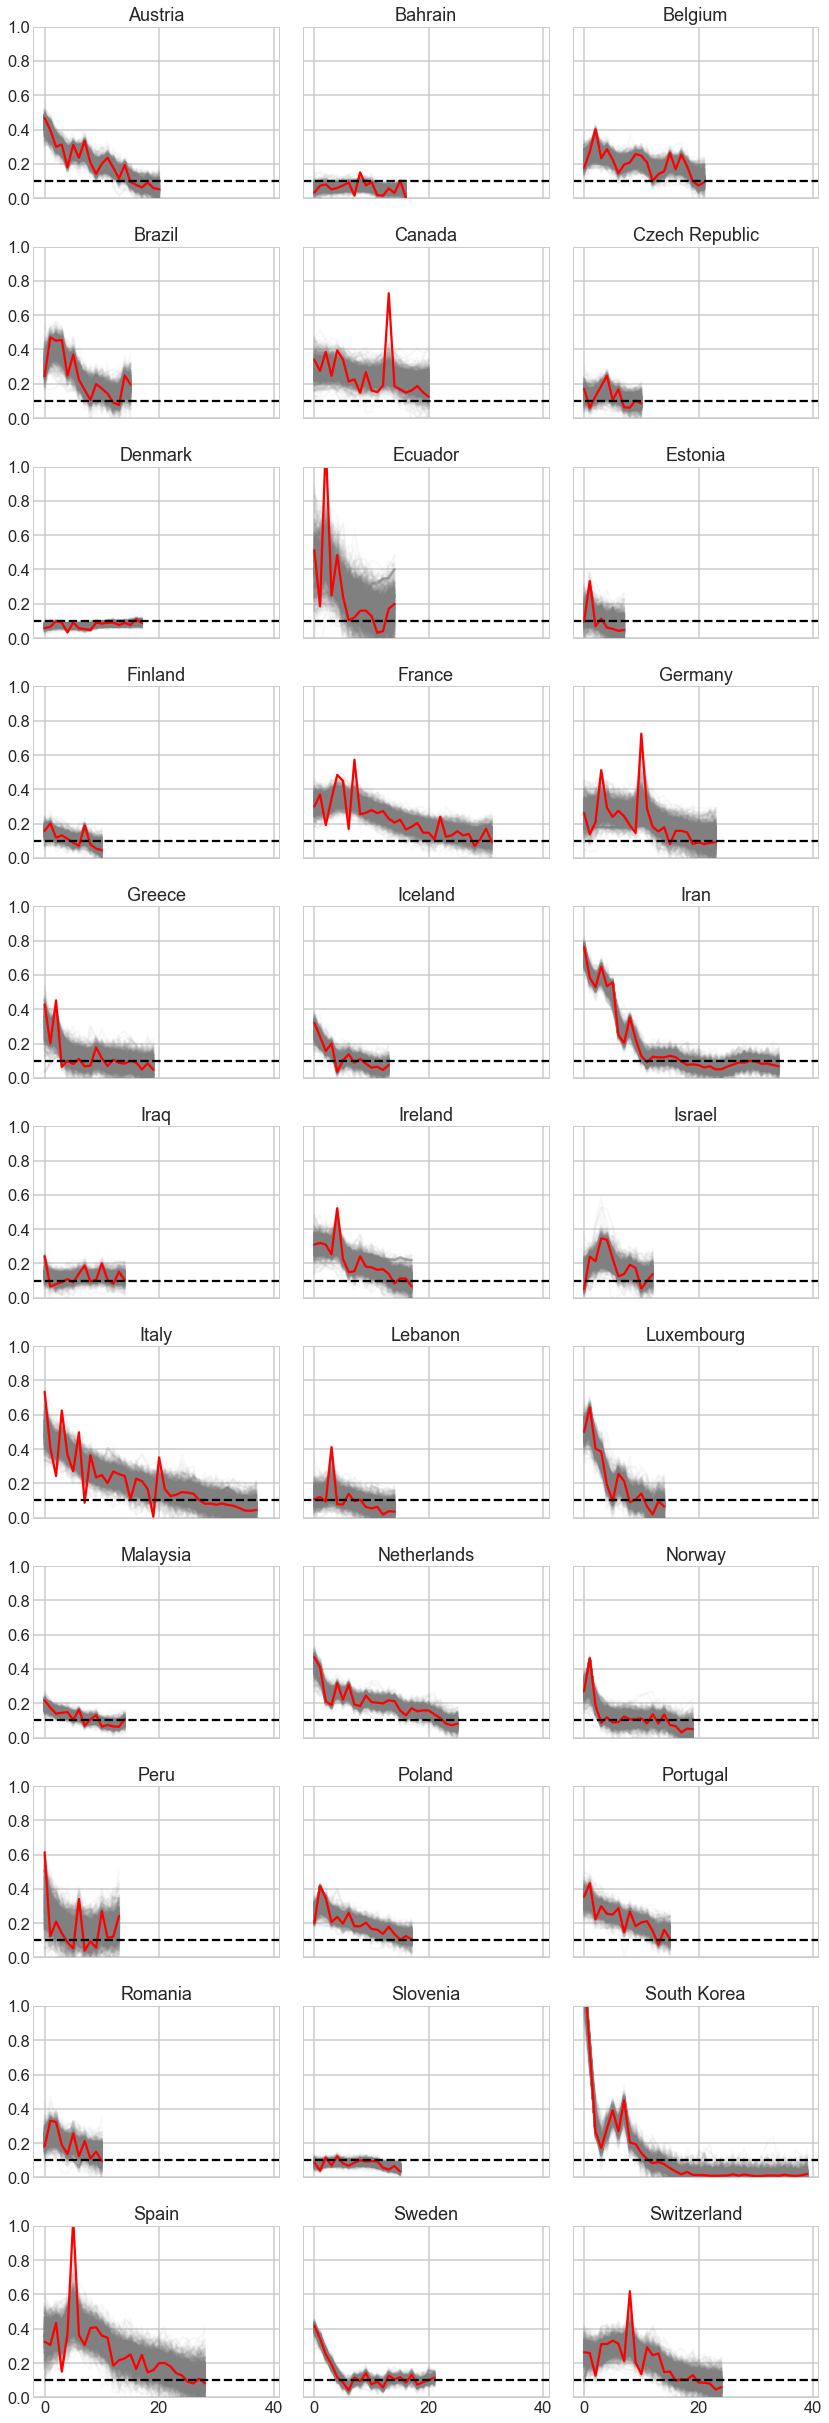

In [197]:
fig, axs = plt.subplots(ncols=3, nrows=n_countries // 3, figsize=(12, 34), sharex=True, sharey=True)
for i, (country, ax) in enumerate(zip(countries, axs.flatten())):
    #ax.plot(df.loc[lambda x: x.country == country].confirmed_pct_change.values, color='r')
    #ax.plot(post_pred[country].T, alpha=.05, color='0.5')
    ax.plot(trace['mu_growth_{}'.format(country)].T, alpha=.05, color='0.5');
    ax.plot(df.loc[lambda x: x.country == country].confirmed_pct_change.values, color='r')
    ax.set(title=country, ylim=(0, 1.0))
    
fig.tight_layout()

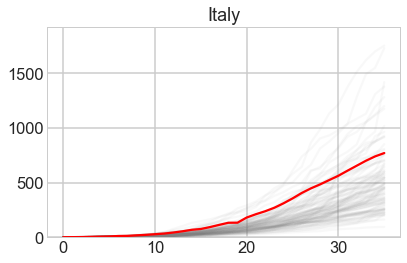

In [144]:
fig, axs = plt.subplots() #ncols=3, nrows=n_countries // 3, figsize=(12, 34), sharex=True, sharey=True)
for i, (country, ax) in enumerate(zip(countries, [axs])): ##.flatten())):
    ax.plot(cumulate(post_pred[country].T), alpha=.05, color='0.5')
    cum_cases = cumulate(df.loc[lambda x: x.country == country].confirmed_pct_change.values)
    ax.plot(cum_cases, color='r')
    ax.set(title=country, ylim=(0, cum_cases.max() * 2.5))
    
fig.tight_layout()

## backup

In [ ]:
with pm.Model() as model:
    #step_width_grp = pm.HalfNormal('step_width_grp', .05)
    step_width = pm.HalfNormal('step_width', .05, shape=n_countries)
    #sigma_growth_grp = pm.HalfNormal('sigma_growth_grp', 1.)
    sigma_growth = pm.HalfNormal('sigma_growth', .5, shape=n_countries)
    
    for i, country in enumerate(countries):
        df_country = df.loc[lambda x: (x.country == country)]
    
        mu_growth = pm.GaussianRandomWalk('mu_growth_{}'.format(country), 
                                          mu=0, sigma=step_width[i],
                                          shape=len(df_country), testval=0.3)
   
    #         obs = pm.Lognormal(country,
    #                        mu=pm.math.log(mu_growth), 
    #                        sigma=sigma_growth[i], 
    #                        observed=df_country.confirmed_pct_change)

        obs = pm.Normal(country, 
                        mu=mu_growth, 
                        sigma=sigma_growth[i], 
                        observed=df_country.confirmed_pct_change)    
    
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))
        
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace, 100)